# Optimal portfolio frontier

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import dataframe_image as dfi
from scipy.stats import norm
from pypfopt.risk_models import exp_cov, cov_to_corr, semicovariance, CovarianceShrinkage

In [2]:
sns.set_theme(style='darkgrid')

In [3]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'AXGICCH LX Equity',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'GSMBIAS LX Equity',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    'HYBRIDCHF': 'NBCHCPA ID Equity',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'SWBHCHP LX Equity',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'SGCIFCH LX equity',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'JPGCHFCP Index': 'CSIFMFH SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'AURLNCHF Curncy': 'AURLNCHF CURNCY',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',
    'SBWGNSUU Index': 'IGLO LN Equity',
    'JHCC1R10 Index': 'X03H SW Equity',
    'M7CXSSD Index' : 'IJPC SW Equity'
    }, inplace=True)

    return portfolio

In [4]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [5]:
def montecarlo_opti(df, df_weight, vol, list_isin, delta=0.005):
    vol_min = vol - delta
    vol_max = vol + delta
    df_strat = df[(df.volatility > vol_min) & (df.volatility < vol_max)]
    optimal_return = df_strat.returns.max()
    optimal_weight = df_weight.loc[df_strat.returns.idxmax()].reindex(list_isin).fillna(0).values
    return optimal_return, optimal_weight

In [6]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    if port_vol == 0:
        port_sharp = 0
    else:
        port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [7]:
def portfolioReturn(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[0]

In [8]:
def portfolioVariance(weights, annual_returns, annual_cov):
    return sigma_to_sharp(weights, annual_returns, annual_cov)[1]

In [9]:
def port_delta(weights, data, delta_ret, delta_var):
    
    annual_returns, annual_cov = get_ret_cov(data)
    annual_cov_best = annual_cov.copy()
    np.fill_diagonal(annual_cov_best, np.diagonal(annual_cov) * (1 - delta_var) )
    annual_returns_best = annual_returns * (1 + delta_ret)
    
    port_ret, port_vol, _ = sigma_to_sharp(weights, annual_returns, annual_cov)
    port_ret_best, port_vol_best, _ = sigma_to_sharp(weights, annual_returns_best, annual_cov_best)
    
    return np.abs(port_ret_best - port_ret), np.abs(port_vol - port_vol_best)

In [10]:
def efficientOpt(x0, annual_returns, annual_cov, ret, A, a_inf, a_sup, B, b_inf, b_sup, bounds):
    num_assets = len(annual_returns)
    args = (annual_returns, annual_cov)

    constraints = ({'type':'ineq', 'fun': lambda x: portfolioReturn(x, annual_returns, annual_cov) - ret},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: A @ x - a_inf},
                   {'type': 'ineq', 'fun': lambda x: - A @ x + a_sup},
                   {'type': 'ineq', 'fun': lambda x: B @ x - b_inf},
                   {'type': 'ineq', 'fun': lambda x: - B @ x + b_sup},
                  )
            
    #bound = constraintSet
    #bounds = tuple(bound for asset in range(num_assets))
    effOpt = sc.minimize(portfolioVariance, x0=x0, args=args, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

# Optimisation

In [11]:
indice_excel = pd.read_excel('pp_data/fund_data.xlsx', sheet_name='indice', header=0, parse_dates=False)
indice_excel = indice_excel[['Nom', 'Valeur', 'PP_L1', 'PP_CHF_L2']].rename(columns={'Valeur': 'No ISIN'})
classe_data = port_filter(indice_excel)

In [12]:
date = '2020-01-01'

In [13]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])

In [14]:
list_isin = ['SBWMSF3L Index', 'SBF14T Index', 'SBWGNSZC Index', 
             'LG30TRCH Index','H00014CH Index', 'UCBIFX28 Index', 
             'SPI Index', 'MXWO Index', 'NDUEEGF Index', 'HFRXGLC Index',
             'SWIIT Index', 'XAU Curncy']
df_list_isin = pd.DataFrame(list_isin, columns=['No ISIN'])
list_isin = list(port_filter(df_list_isin)['No ISIN'])
list_nom = ['Cash CHF','Obl. Suisse','Obl. Monde',
            'Obl. HY', 'Obl. EM', 'Obl. Convertible','Actions Suisse','Actions Monde','Actions EM','Hedge Fund',
            'Real Estate','Or']
ticker_nom = pd.DataFrame(data=zip(list_isin, list_nom), columns=['ticker', 'nom'])

In [15]:
list_saa = [0.05, 0.23, 0.075, 0.015, 0.015, 0.015, 0.189, 0.227, 0.064, 0.06, 0.03, 0.03]

In [16]:
saa = pd.DataFrame(zip(list_isin, list_saa), columns=['Ticker', 'weight'])

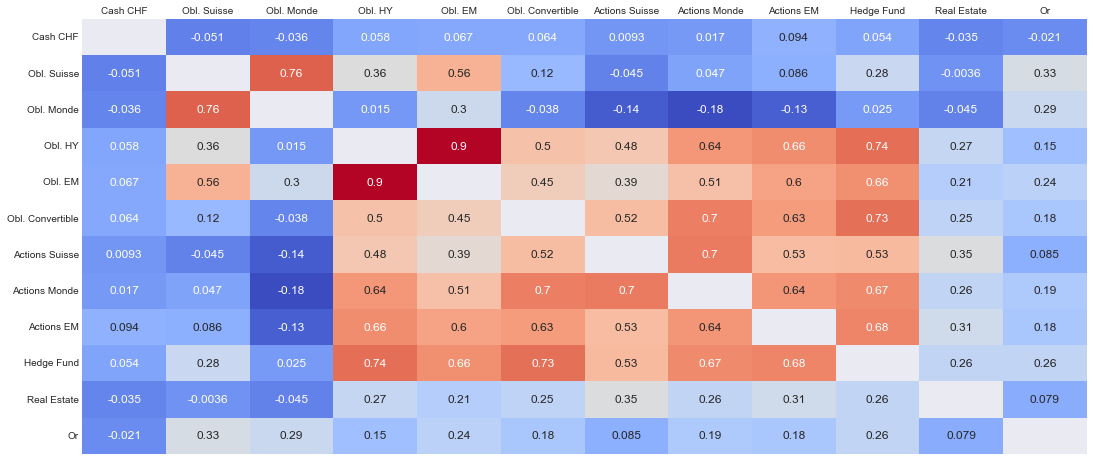

In [26]:
data_2020 = data_excel.copy().fillna(method='ffill').loc[date:]
data_2020 = data_2020[list_isin]
data_2020.columns = list_nom

corr_2020 = data_2020.pct_change().corr()

fig, ax = plt.subplots(figsize=(18,8))

mask = np.identity(12)
sns.heatmap(data=corr_2020, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))

ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True, length=0)
plt.savefig('PP_output/opti/correlation.png', dpi=300, bbox_inches='tight')
plt.show()

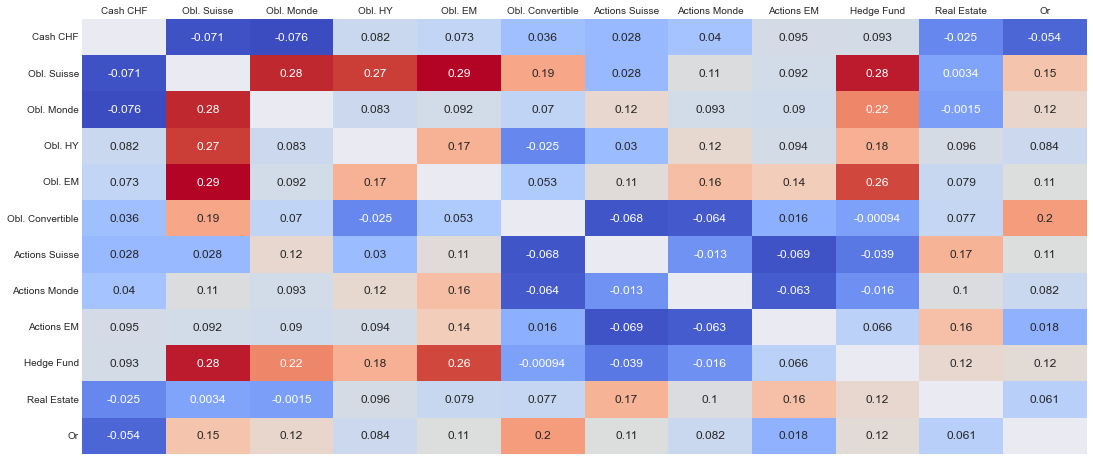

In [30]:
fig, ax = plt.subplots(figsize=(18,8))

mask = np.identity(12)
sns.heatmap(data=corr_2020 - corr, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))

ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True, length=0)
plt.savefig('PP_output/opti/correlation.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
data = data_excel.copy().fillna(method='ffill')
list_isin_nom = pd.DataFrame(data=list_isin, columns=['No ISIN']).merge(classe_data, on='No ISIN', how='left')['Nom'].to_list()
data = data[list_isin]#.dropna()
data.columns = list_nom
num_assets_data = data.shape[1]

daily_returns = data.pct_change()
daily_returns.columns = list_nom
annual_returns_histo = ((1 + daily_returns.mean())**252 - 1).values
daily_cov = daily_returns.cov()
annual_cov_histo = daily_cov.values * 252

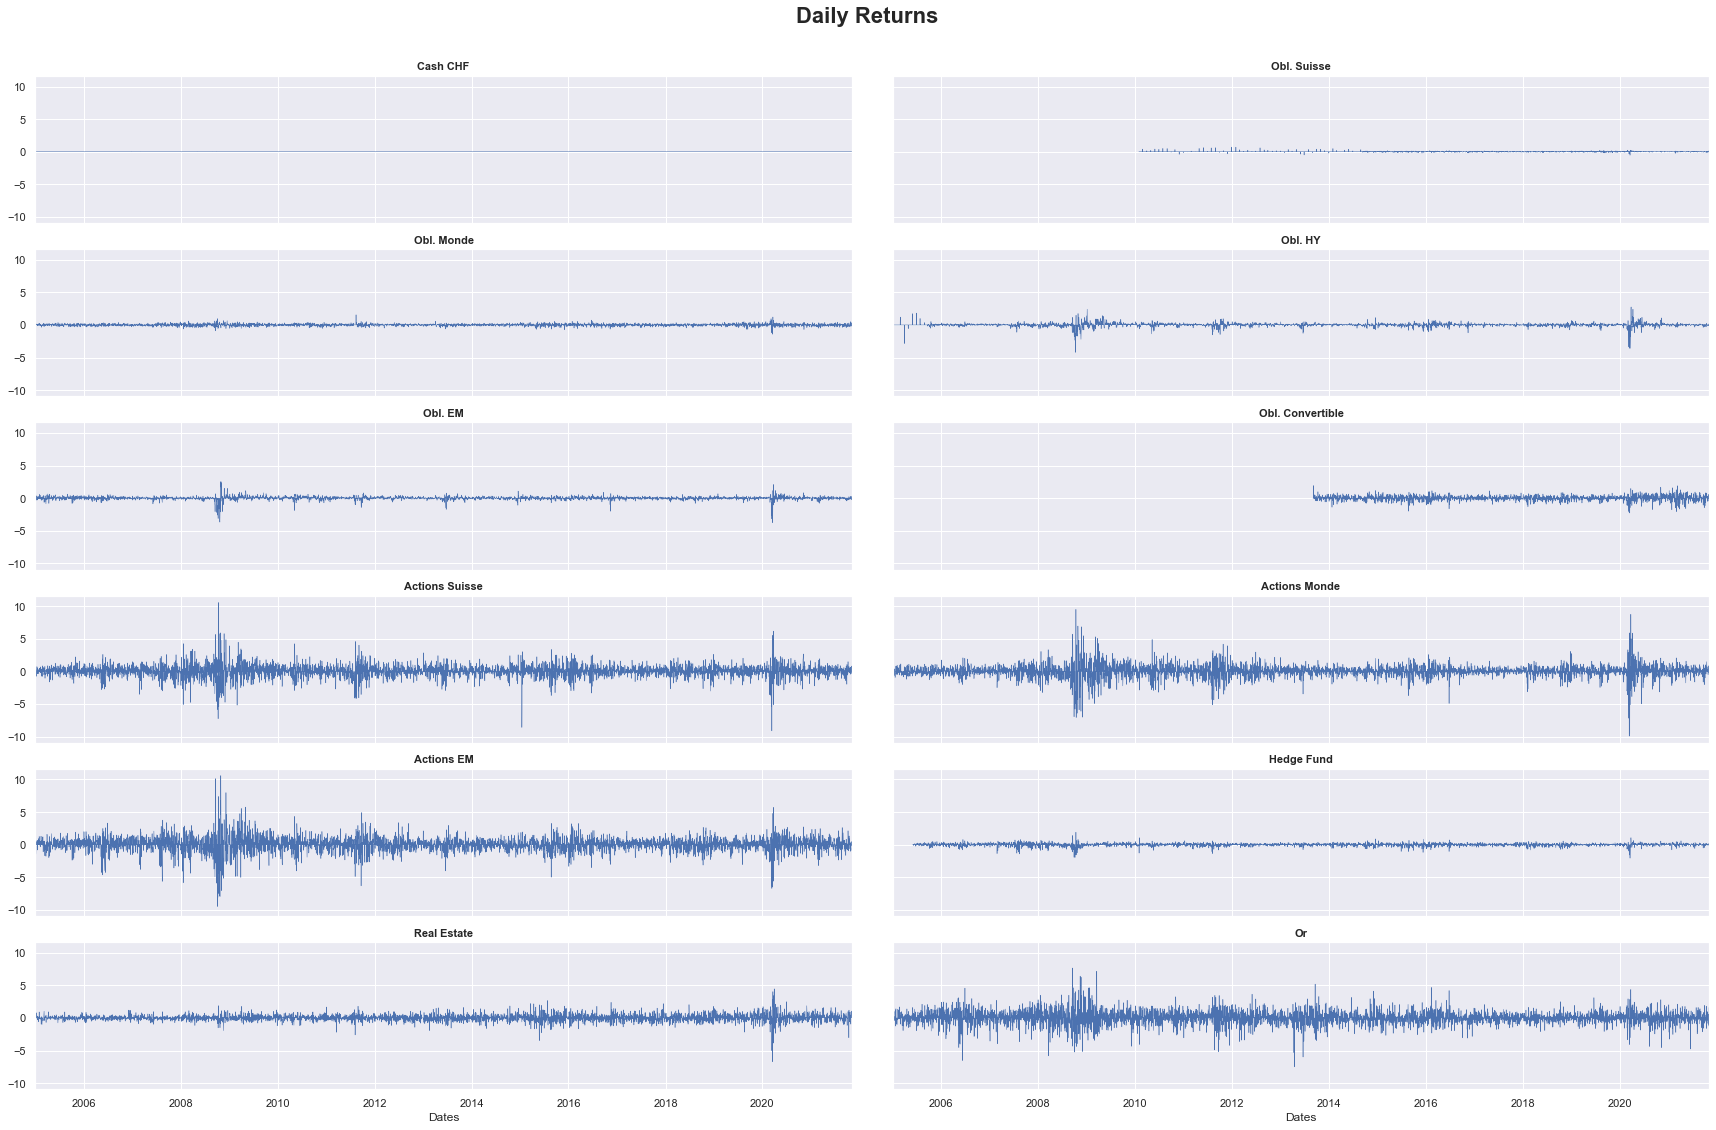

In [20]:
fig, axs = plt.subplots(6, 2, figsize=(24,16), sharex=True, sharey=True)
for i, col in enumerate(data.columns):
    axs = axs.ravel()
    (data[col].dropna().pct_change() * 100).plot(lw=0.5, ax=axs[i])
    axs[i].grid(b=True)
    axs[i].set_title(col, fontweight='bold', fontsize=11)

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, top=0.92)
fig.suptitle('Daily Returns', fontsize=22, fontweight='bold', x=0.505)
plt.savefig('PP_output/opti/daily_returns.png', dpi=200, bbox_inches='tight')
plt.show()

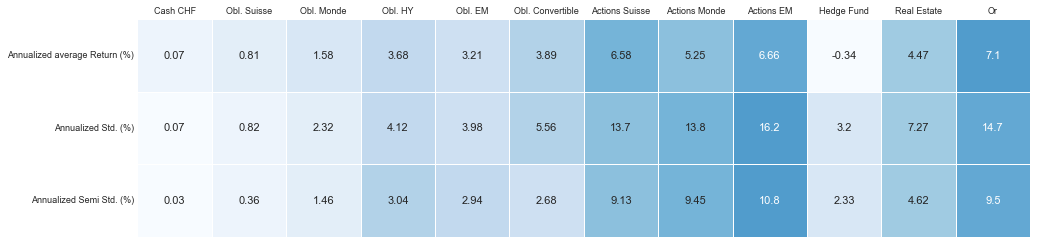

In [21]:
data_histo = np.vstack((annual_returns_histo * 100, 
                       (daily_returns.std() * np.sqrt(252) * 100).values, 
                       (np.fmin(daily_returns, 0).std() * np.sqrt(252) * 100).values))

df_data_histo = pd.DataFrame(data=data_histo, columns=list_nom, index=['Annualized average Return (%)', 'Annualized Std. (%)', 'Annualized Semi Std. (%)']).round(2)
                       
#df_data_histo_plot = df_data_histo.T.reset_index(drop=False)
#df_data_histo_plot.columns = ['asset', 'return', 'Standard Deviation', 'Semi Deviation']
#dfi.export(df_data_histo, 'PP_output/opti/histo_stats.png')
#df_data_histo

fig, ax = plt.subplots(figsize=(16,4))
sns.heatmap(data=df_data_histo.rank(axis=1), annot=df_data_histo, cmap='Blues', cbar=False, vmax=20, linewidth=1, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=9, labelbottom=False, labeltop=True, labelrotation=0, length=0)
plt.savefig('PP_output/opti/stats.png', dpi=300, bbox_inches = "tight")
plt.show()

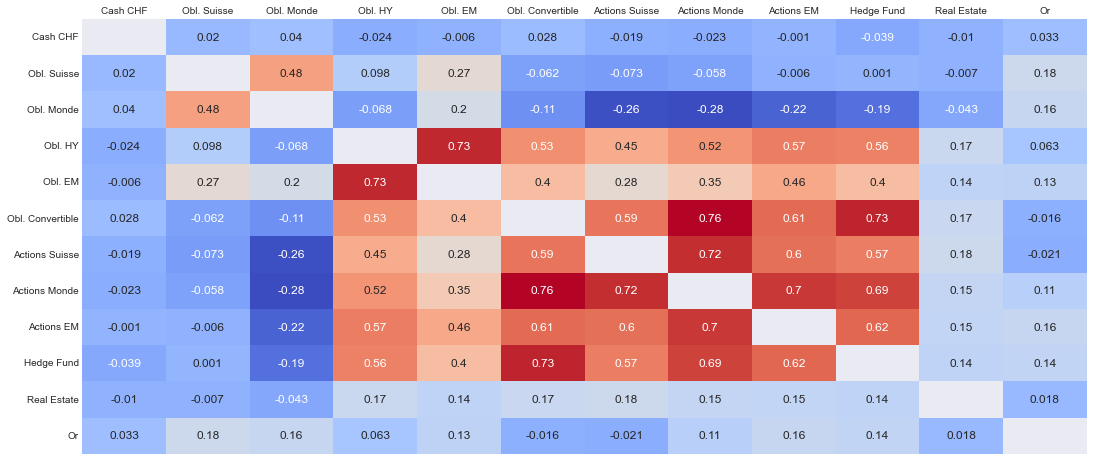

In [22]:
corr = daily_returns.corr().round(3)

fig, ax = plt.subplots(figsize=(18,8))

mask = np.identity(12)
#mask = np.zeros_like(corr)
#mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=corr, annot=True, cmap='coolwarm', cbar=False, mask=mask, annot_kws=dict(size=12))

ax.tick_params(axis='both', which='major', labelsize=10, labelbottom=False,labeltop=True, length=0)
plt.savefig('PP_output/opti/correlation.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
A = np.array([[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]])

B = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

a_inf = np.array([0.015, 0.42])
a_sup = np.array([0.075, 0.54])

b_inf = np.array([0.049, 0.15, 0., 0.139, 0.177, 0.014, 0.03, 0., 0.])
b_sup = np.array([0.051, 0.40, 0.15, 0.239, 0.277, 0.114, 0.09, 0.06, 0.06])

In [22]:
bounds = [
    (0.0499, 0.0501),
    (0.15, 0.40),
    (0., 0.15),
    (0., 1.),
    (0., 1.),
    (0., 1.),
    (0.139, 0.239),
    (0.177, 0.277),
    (0.014, 0.114),
    (0.03, 0.09),
    (0., 0.06),
    (0., 0.06)
]

asset_opti = []
group_matrix = np.array([ [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

for i in range(len(df_opti_weight_histo)):
    asset_opti.append(group_matrix @ df_opti_weight_histo.iloc[i].values)
asset_opti = np.array(asset_opti)
list_asset = ['Liquidité', 'Obligations', 'Obligations à risque', 'Actions', 'Alternatifs']

fig, ax = plt.subplots(figsize=(16,8))
palette = sns.color_palette('hls', n_colors=len(list_asset))
ax.stackplot(df_opti_weight_histo.index, 100 * asset_opti.T, baseline='zero', labels=list_asset, colors=palette, linewidth=0)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.22, 1), fontsize=15, frameon=False)
ax.grid()
plt.title('Optimal asset allocation (Equilibré CHF) with historical average returns', fontweight='bold', fontsize=15)
plt.ylabel('Weight (%)')
plt.xlabel('Volatility (%)')
plt.savefig('pp_output/opti/asset_alloc_histo.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
plt.show()

In [23]:
df_scenarios = pd.read_excel('PP_data/scenarios.xlsx', sheet_name='scenarios2')
df_scenarios.rename(columns={'Ticker': 'No ISIN'}, inplace=True)
df_scenarios = port_filter(df_scenarios)
df_scenarios.index = df_scenarios['No ISIN']
df_scenarios.drop(columns='No ISIN', inplace=True)
df_scenarios.reindex(list_isin)
df_scenarios.index = list_nom
df_scenarios.index.name = None
df_scenarios['Historique'] = annual_returns_histo

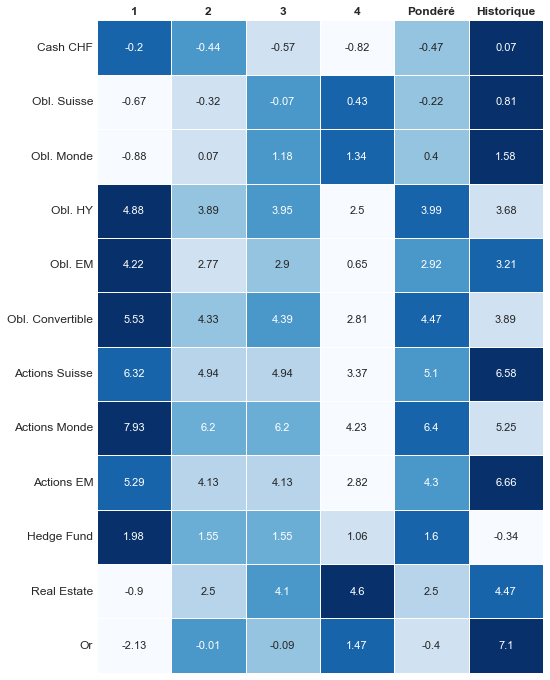

In [24]:
fig, ax = plt.subplots(figsize=(8,12))
sns.heatmap(data=df_scenarios.rank(axis=1), annot=(df_scenarios * 100).round(2), cmap='Blues', cbar=False, linewidth=1, annot_kws=dict(size=11), fmt='.3g')
ax.tick_params(axis='both', which='major', labelsize=12, labelbottom=False, labeltop=True, labelrotation=0, length=0)
ax.set_xticklabels(ax.get_xticklabels(), weight='bold')
plt.savefig('PP_output/opti/scenarios.png', dpi=300, bbox_inches = "tight")
plt.show()

 25%|██▌       | 25/100 [00:00<00:01, 48.14it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 24.80it/s]


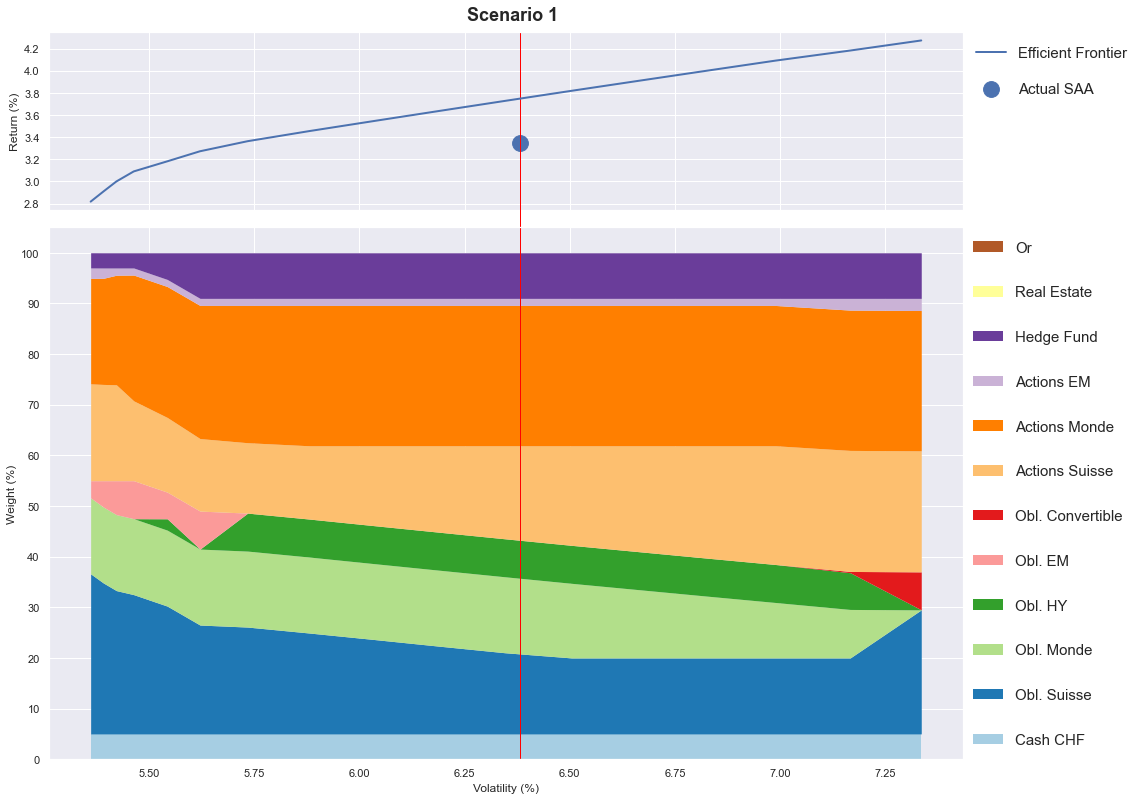

 20%|██        | 20/100 [00:00<00:01, 65.09it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


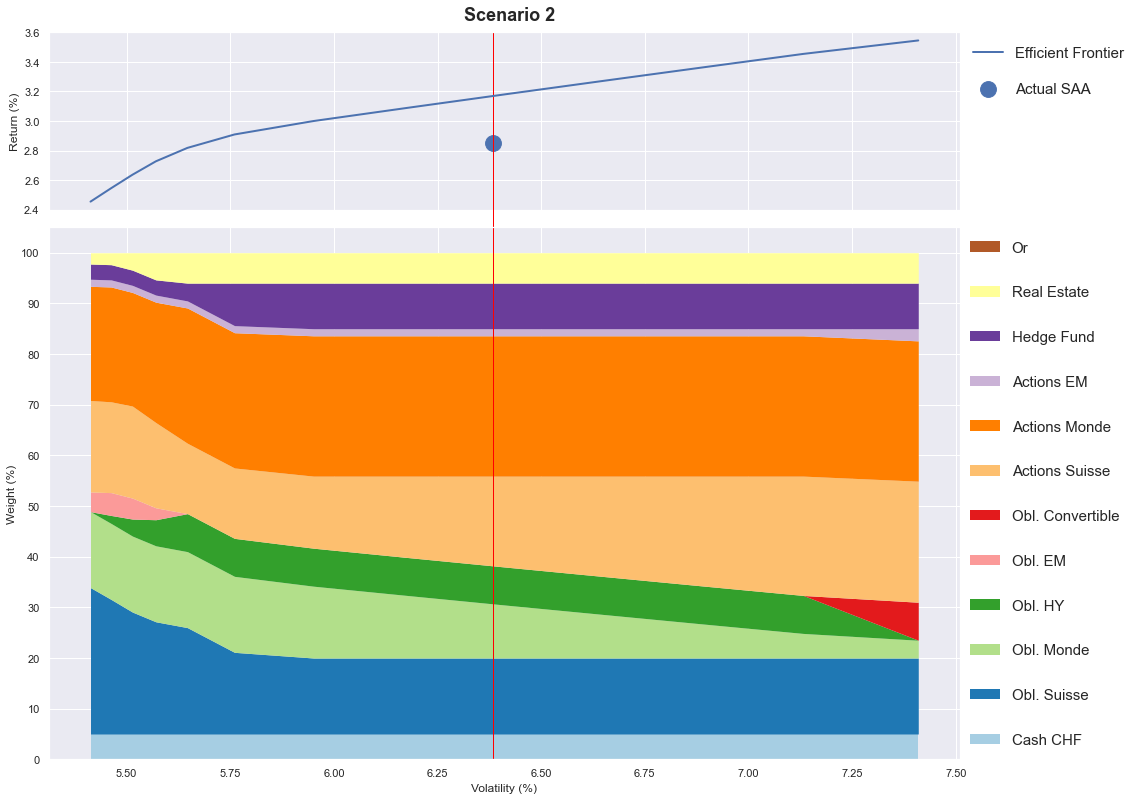

 22%|██▏       | 22/100 [00:00<00:01, 65.59it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 24.86it/s]


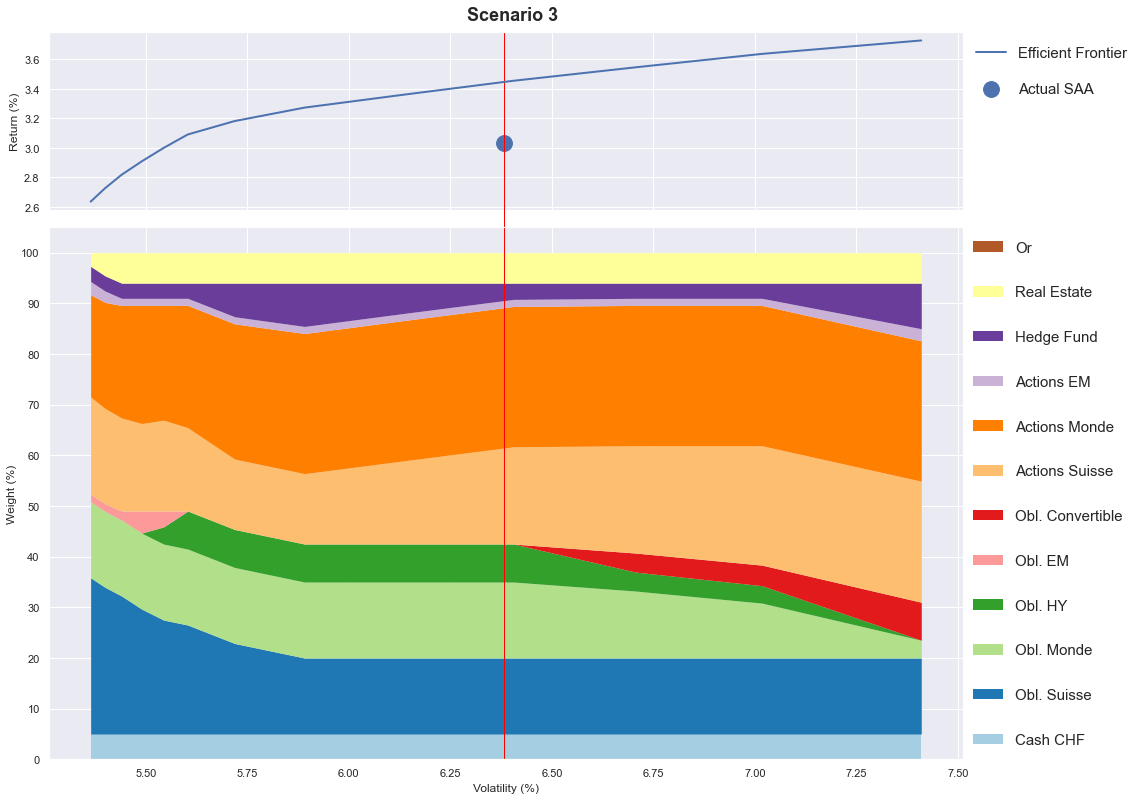

 13%|█▎        | 13/100 [00:00<00:01, 58.67it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:05<00:00, 18.91it/s]


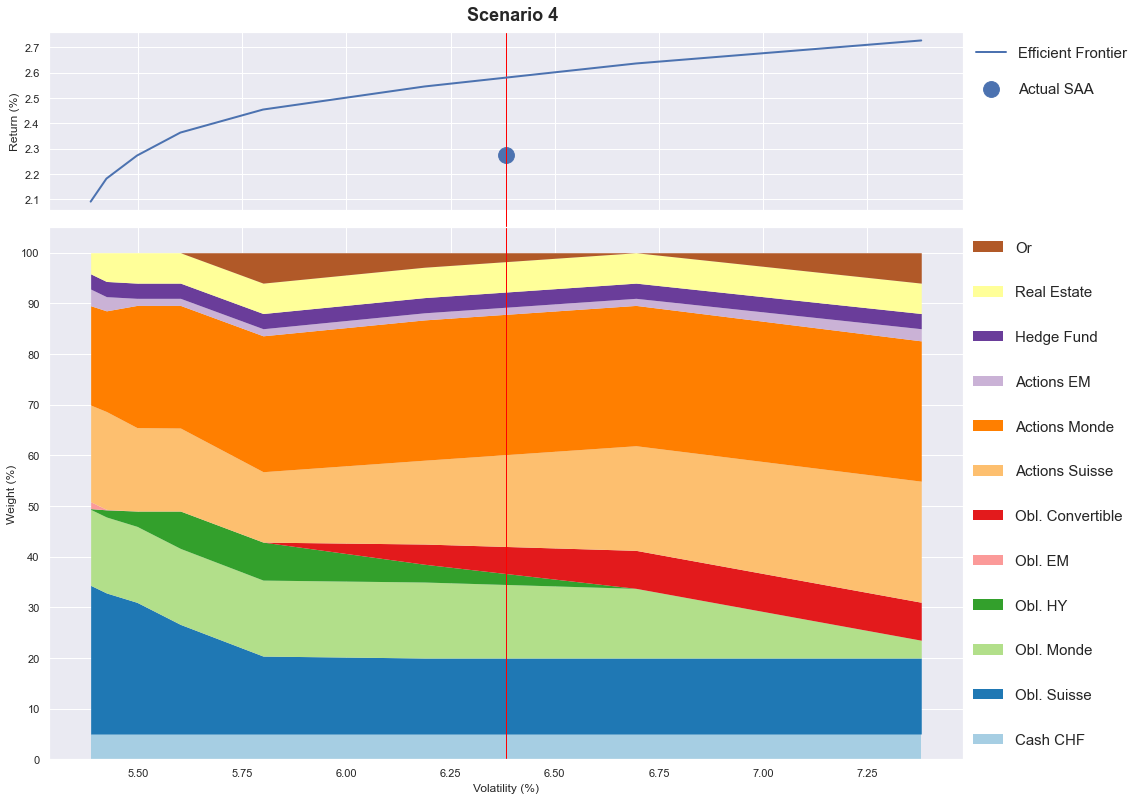

 24%|██▍       | 24/100 [00:00<00:01, 54.13it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 20.82it/s]


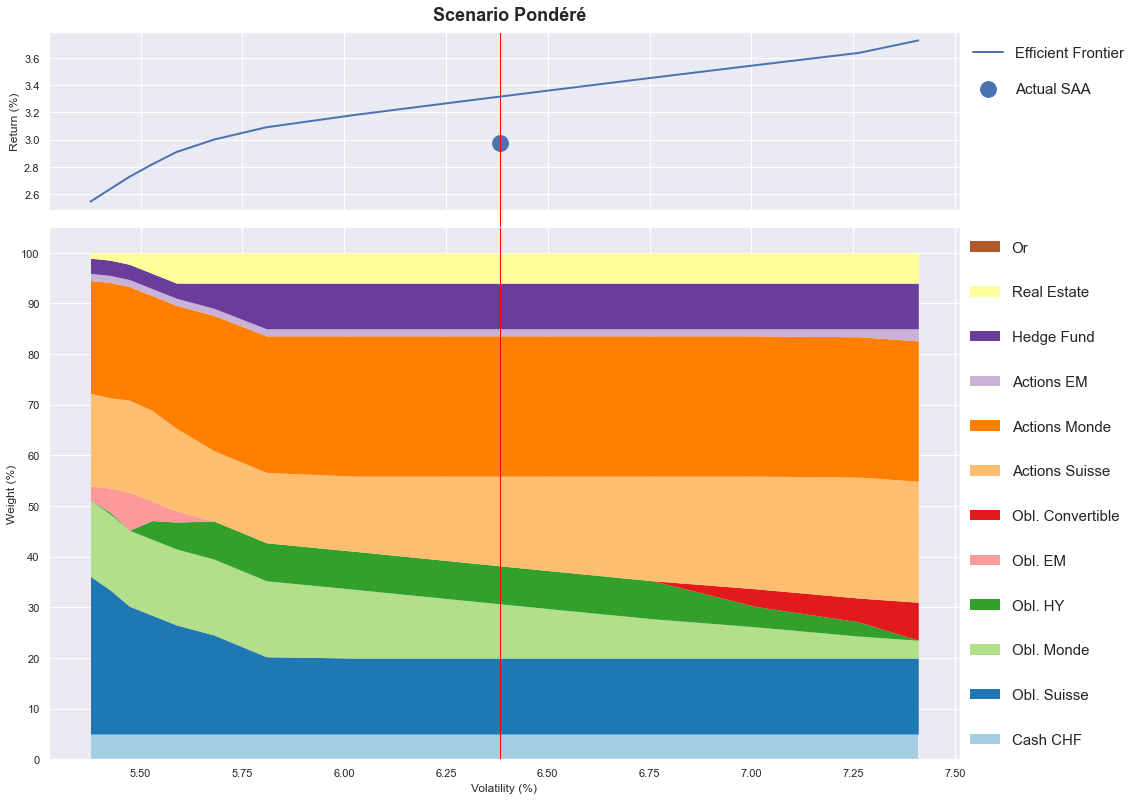

 58%|█████▊    | 58/100 [00:02<00:03, 12.38it/s]/Users/lacoupe/Documents/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 100/100 [00:04<00:00, 21.01it/s]


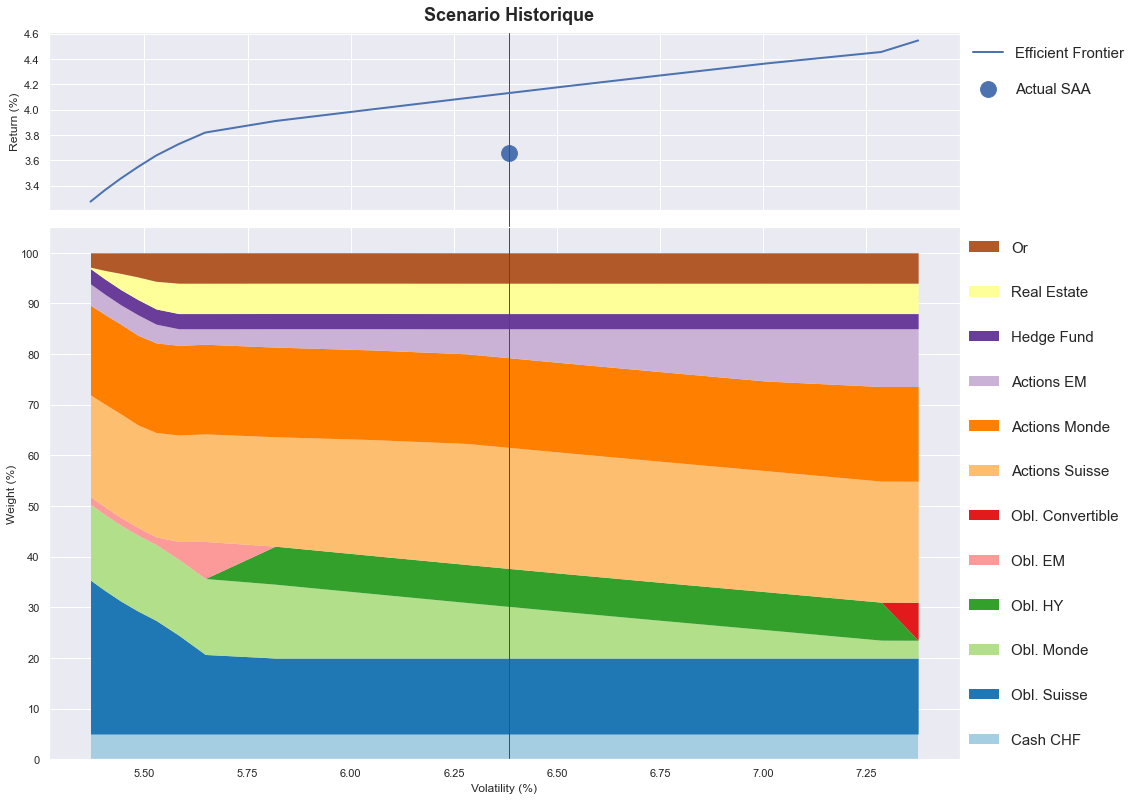

In [25]:
scenarios = list(df_scenarios.columns)
df_vol_all = pd.DataFrame()
dict_vol_all = {}
dict_weight_all = {}
dict_saa_all = {}

for i, scen in enumerate(scenarios):
    annual_returns = df_scenarios[scen].values
    
    # Optimisation
    opti_vol = []
    ret_min = 0.01
    ret_max = 0.10
    ret_grid = np.linspace(ret_min, ret_max, 100)
    opti_weight=[]
    x0 = np.array(saa.weight)
    for ret in tqdm(ret_grid):
        results = efficientOpt(x0, annual_returns, annual_cov_histo, ret, 
                               A=A, a_inf=a_inf, a_sup=a_sup, B=B, b_inf=b_inf, b_sup=b_sup, bounds=bounds)
        opti_vol.append(results['fun'])
        opti_weight.append(results['x'])

    opti_vol = 100 * np.array(opti_vol)
    ret_grid = 100 * np.array(ret_grid)
    opti_weight = np.array(opti_weight)
    opti_weight = opti_weight.round(4)

    df_vol = pd.DataFrame(data=zip(opti_vol, ret_grid), columns=['vol', 'ret'])
    df_vol['scenario'] = 'Scenario ' + str(scen)
    df_vol = df_vol[df_vol.vol.diff() > 0.01]
    df_vol = df_vol.round(4).drop_duplicates(subset=('vol'))
    df_vol = df_vol.iloc[1:]
    
    dict_vol_all[scen] = df_vol
    df_vol_all = pd.concat([df_vol_all, df_vol])
    
    df_opti_weight = pd.DataFrame(data=opti_weight, columns=list_isin)
    df_opti_weight = df_opti_weight.reindex(df_vol.index)
    df_opti_weight.index = df_vol[df_vol.columns[0]]
    df_opti_weight = df_opti_weight.sort_index()
    df_opti_weight.columns = list_nom
    df_opti_weight.fillna(0, inplace=True)

    dict_weight_all[scen] = df_opti_weight
    asset_opti = []
    group_matrix = np.array([ [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]])

    list_asset = ['Liquidité', 'Obligations', 'Obligations à risque', 'Actions', 'Alternatifs']

    for i in range(len(df_opti_weight)):
        asset_opti.append(group_matrix @ df_opti_weight.iloc[i].values)
    asset_opti = np.array(asset_opti)
    
    port_ret, port_vol = 100 * portfolioReturn(saa.weight, annual_returns, annual_cov_histo), \
                         100 * portfolioVariance(saa.weight, annual_returns, annual_cov_histo)
    
    dict_saa_all[scen] = port_vol
    
    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(16,12), sharex=True, gridspec_kw={'height_ratios': [1, 3]})
    axs = axs.ravel()
    palette_indices = sns.color_palette('Paired', n_colors=len(list_nom))
    palette_asset = sns.color_palette('hls', n_colors=len(list_asset))

    sns.lineplot(ax=axs[0], data=df_vol, x='vol', y='ret', sort=False, lw=2, palette="flare", label='Efficient Frontier')
    axs[0].scatter(x=port_vol, y=port_ret, s=250, label='Actual SAA')
    handles0, labels0 = axs[0].get_legend_handles_labels()
    lgd0 = axs[0].legend(handles0, labels0, bbox_to_anchor = (1, 1), fontsize=15, labelspacing=1.5, frameon=False)
    axs[0].grid(b=True)
    axs[0].axvline(x=port_vol , ymin=-1.2, ymax=1, c="red",linewidth=1, zorder=1, clip_on=False)
    axs[0].set_ylabel('Return (%)', fontsize=12)

    axs[1].stackplot(df_opti_weight.index, 100 * df_opti_weight.values.T, labels=list_nom, colors=palette_indices, linewidth=0)
    handles1, labels1 = axs[1].get_legend_handles_labels()
    lgd1 = axs[1].legend(reversed(handles1), reversed(labels1), bbox_to_anchor = (1.19, 1), fontsize=15, labelspacing=2.05, frameon=False)
    axs[1].grid(b=True)
    axs[1].axvline(x=port_vol ,ymin=0, ymax=1.2, c="red", linewidth=1, zorder=1, clip_on=False)
    axs[1].set_ylabel('Weight (%)', fontsize=12)
    axs[1].set_xlabel('Volatility (%)', fontsize=12)
    axs[1].locator_params(nbins=15, axis='y')

    #axs[2].stackplot(df_opti_weight.index, 100 * asset_opti.T, labels=list_asset, colors=palette_asset)
    #handles2, labels2 = axs[2].get_legend_handles_labels()
    #lgd = axs[2].legend(reversed(handles2), reversed(labels2), bbox_to_anchor = (1.182, 1), fontsize=12)
    #axs[2].axvline(x=port_vol ,ymin=0, ymax=1.2, c="red", linewidth=1, zorder=1, clip_on=False)
    #axs[2].grid()
    #axs[2].set_xlabel('Volatility (%)', fontsize=12)
    
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.05, top=0.95)
    title = 'Scenario ' + str(scen)
    fig.suptitle(title, fontsize=18, fontweight='bold', x=0.45)
    
    path = 'pp_output/opti/indice_alloc_scenario_' + str(scen) + '.png'
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.show()

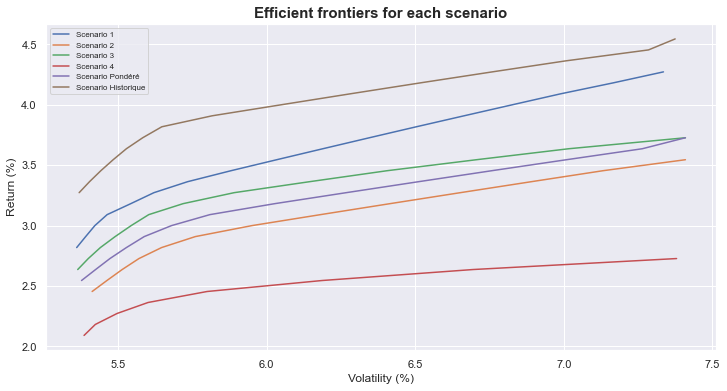

In [26]:
fig, ax =plt.subplots(figsize=(12,6))
for scen in scenarios:
    style = '-'
    if scen == 'Equal Weighted':
        style = '--'
    sns.lineplot(data=dict_vol_all[scen], x='vol', y='ret', label='Scenario ' + str(scen), linestyle=style)
plt.legend(fontsize=8)
plt.xlabel('Volatility (%)')
plt.ylabel('Return (%)')
plt.title('Efficient frontiers for each scenario', fontweight='bold', fontsize=15)
plt.grid(b=True)
plt.savefig('PP_output/opti/mpt_comparison.png', dpi=300, bbox_inches='tight')

In [27]:
df_opti_resume = pd.DataFrame(index=list_nom, columns=['SAA Actuel', 'Histo. returns'] + scenarios)
df_opti_resume['SAA Actuel'] = saa.weight.values
idx = df_opti_weight_histo.reset_index()['vol'].sub(port_vol_histo).abs().idxmin()
df_opti_resume['Histo. returns'] = df_opti_weight_histo.iloc[idx].values
for scen in scenarios:
    port_vol = dict_saa_all[scen]
    df_opti_weight = dict_weight_all[scen]
    idx = df_opti_weight.reset_index()['vol'].sub(port_vol).abs().idxmin()
    df_opti_resume[scen] = df_opti_weight.iloc[idx].values
df_opti_resume = (df_opti_resume * 100).round(1)

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(data=df_opti_resume, annot=True, cmap='Blues', cbar=False, linewidths=1, linecolor='black')
ax.tick_params(axis='both', which='major', labelsize=13, labelbottom=False, labeltop=True)
plt.xticks(weight='bold')

plt.savefig('PP_output/opti/weight_resume.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'df_opti_weight_histo' is not defined